In [7]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('equipment_tuning_dataset.csv')
df.head(); df.info(); df.describe(include='all')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1250 entries, 0 to 1249
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   F1            1250 non-null   float64
 1   F2            1250 non-null   float64
 2   F3            1154 non-null   float64
 3   F4            1250 non-null   float64
 4   F5            1250 non-null   float64
 5   F6            1250 non-null   float64
 6   F7            1250 non-null   object 
 7   F8            1250 non-null   object 
 8   F9            1166 non-null   float64
 9   F10           1250 non-null   object 
 10  F11           1250 non-null   int64  
 11  F12           1250 non-null   float64
 12  Needs_Tuning  1250 non-null   object 
dtypes: float64(8), int64(1), object(4)
memory usage: 127.1+ KB


,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,Needs_Tuning
count,1250.000000,1250.000000,1154.000000,1250.000000,1250.000000,1250.000000,1250,1250,1166.000000,1250,1250.000000,1250.000000,1250
unique,NaN,NaN,NaN,NaN,NaN,NaN,10,3,NaN,4,NaN,NaN,2
top,NaN,NaN,NaN,NaN,NaN,NaN,S08,B,NaN,Z2,NaN,NaN,No
freq,NaN,NaN,NaN,NaN,NaN,NaN,135,433,NaN,351,NaN,NaN,699
mean,50.377088,40.008520,0.001929,29.939434,-0.007571,99.639747,NaN,NaN,0.496415,NaN,0.393600,4.932048,NaN
std,9.888929,29.779004,1.032088,7.931443,1.299155,15.641065,NaN,NaN,0.189756,NaN,0.488743,2.009101,NaN
min,17.587327,8.509809,-2.991136,2.810627,-8.982136,51.684755,NaN,NaN,0.000000,NaN,0.000000,-2.514871,NaN
25%,43.623482,25.130379,-0.712209,24.761290,-0.577992,88.936602,NaN,NaN,0.367878,NaN,0.000000,3.605815,NaN
50%,50.446917,33.708265,0.000185,29.827150,-0.032091,99.380286,NaN,NaN,0.496255,NaN,0.000000,4.967375,NaN
75%,56.612341,46.125163,0.678943,35.274016,0.524421,110.526491,NaN,NaN,0.625014,NaN,1.000000,6.339384,NaN


# 1. Exploratory Data Analysis (EDA)
Identify missing values and outliers, visualize distributions, and analyze class balance.

F1              0.0000
F2              0.0000
F3              0.0768
F4              0.0000
F5              0.0000
F6              0.0000
F7              0.0000
F8              0.0000
F9              0.0672
F10             0.0000
F11             0.0000
F12             0.0000
Needs_Tuning    0.0000
dtype: float64


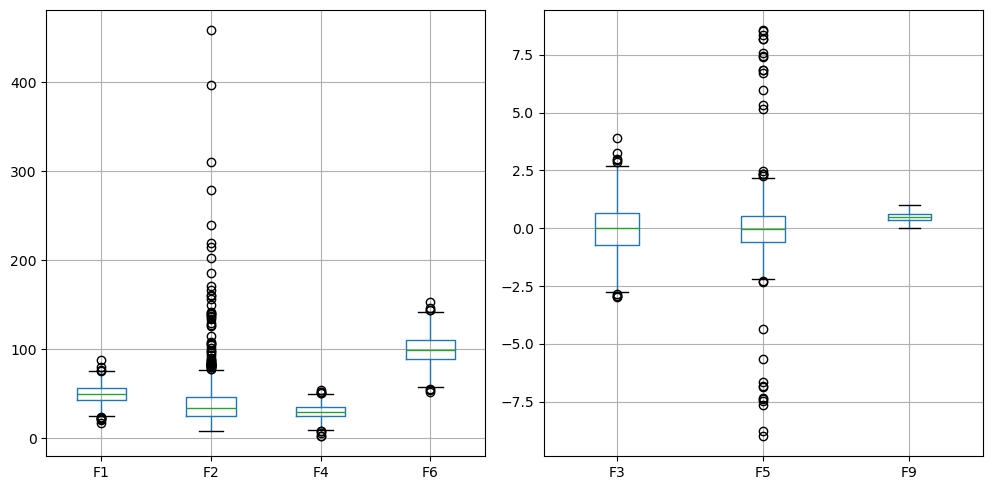

In [27]:
# Identify
print(df.isna().mean()) # fraction missing per column

plt.figure(figsize=(15, 5))

plt.subplot(1,3,1)
df[[ 'F1', 'F2', 'F4', 'F6']].boxplot()

plt.subplot(1,3,2)
df[[ 'F3', 'F5', 'F9']].boxplot()



plt.tight_layout()
plt.show()

In [ ]:
# Simple handling
df['F3'] = df['F3'].fillna(df['F3'].median())
df['F9'] = df['F9'].fillna(df['F9'].median())